In [14]:
import os
import sys
import pickle
import numpy as np
from scipy import stats
from sklearn.metrics import mean_squared_error

sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
from bayesmf.scripts.utils.model import run_kfold_xval
from bayesmf.scripts.utils.dataset import make_insilico_dataset, make_downsampled_dataset
from bayesmf.models.bmf import BMF, StochasticBMF

%reload_ext autoreload
%autoreload 2

import seaborn as sns
import matplotlib.pyplot as plt

In [99]:
X, _ = make_insilico_dataset()

In [113]:
idxs = np.arange(X.shape[1])

np.random.seed(22690)
np.random.shuffle(idxs)

X_train = X[:, idxs[:800]]
X_test = X[:, idxs[800:]]

In [114]:
factorizer = BMF(K=15, random_state=22690, init='nmf')
factorizer.fit(X_train) 
W = factorizer.transform(X_test, attr='Et').T 
H = factorizer.Eb.T

/home/sxchao/bayesmf/models/bmf.py:139: RuntimeWarning: invalid value encountered in double_scalars
  chg = (elbo_new - elbo_old) / abs(elbo_old)
/home/sxchao/bayesmf/models/bmf.py:139: RuntimeWarning: invalid value encountered in double_scalars
  chg = (elbo_new - elbo_old) / abs(elbo_old)


In [115]:
X_pred = np.matmul(W, H)
sqerr = (X_test.T - X_pred)**2

In [116]:
x = np.sqrt(np.sum(X_pred, axis=1))
y = np.sqrt(np.sum(sqerr, axis=1) / 100)

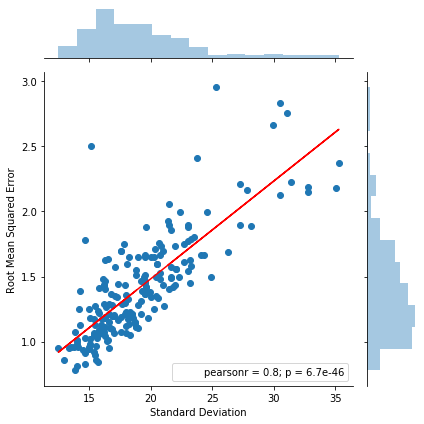

In [139]:
jp = sns.jointplot(x=x, y=y, stat_func=stats.pearsonr)
jp.set_axis_labels('Standard Deviation', 'Root Mean Squared Error')

linreg = stats.linregress(x, y)
jp.ax_joint.plot(x, linreg.intercept + linreg.slope * x, 'r')

plt.tight_layout()
plt.show()

In [21]:
from sklearn.manifold import TSNE

In [112]:
X, _ = make_downsampled_dataset()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [121]:
#X_train = X[:, idxs[:800]]
#X_test = X[:, idxs[800:]]

factorizer = BMF(K=15, random_state=22690, init='nmf')
factorizer.fit(X)

#W = factorizer.transform(X_test, attr='Et').T 
W = factorizer.Et.T
H = factorizer.Eb.T
X_pred = np.matmul(W, H)

/home/sxchao/bayesmf/models/bmf.py:139: RuntimeWarning: invalid value encountered in double_scalars
  chg = (elbo_new - elbo_old) / abs(elbo_old)


In [67]:
#emb = TSNE(n_components=2).fit_transform(W)
#emb.shape

(1000, 2)

In [107]:
import umap
reducer = umap.UMAP()
embedding = reducer.fit_transform(W)
embedding.shape

(1000, 2)

In [222]:
idxs = np.nonzero(np.array(cl) == 7)[0]
len(idxs)

300

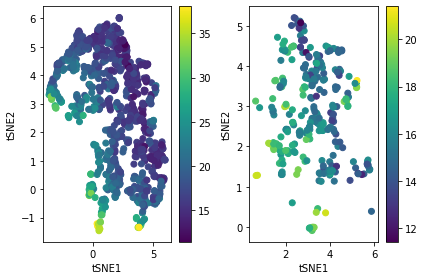

In [157]:
c = np.sqrt(np.sum(X_pred, axis=1))
#sqerr = (X.T - X_pred)**2
#c = np.sqrt(np.sum(sqerr, axis=1) / 100)

plt.subplot(1, 2, 1)
plt.scatter(x=embedding[:,0], y=embedding[:,1], c=c)
plt.xlabel('tSNE1')
plt.ylabel('tSNE2')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.scatter(x=embedding[idxs,0], y=embedding[idxs,1], c=c[idxs])
plt.xlabel('tSNE1')
plt.ylabel('tSNE2')
plt.colorbar()

plt.tight_layout()
plt.show()

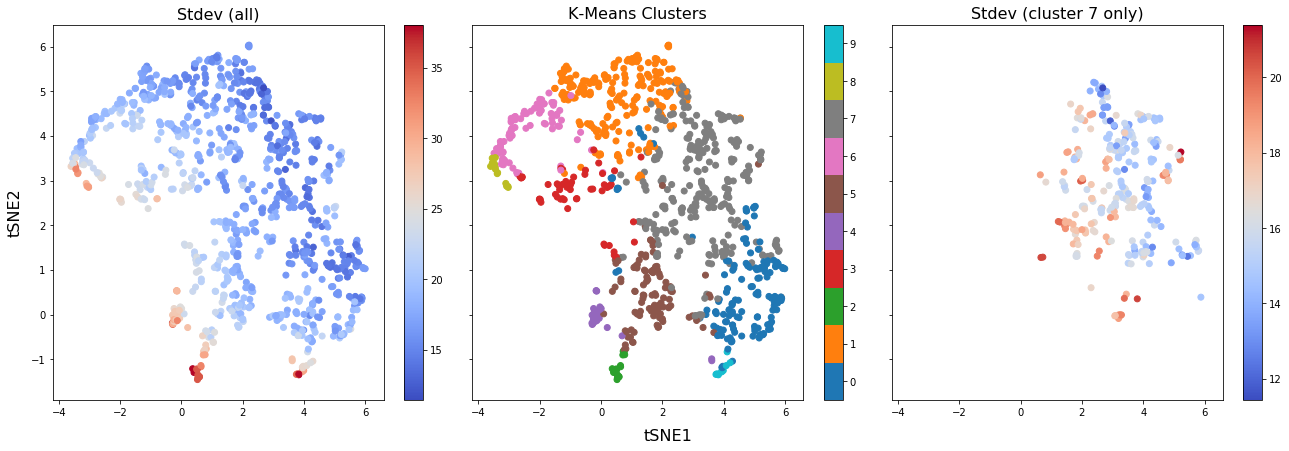

In [227]:
import matplotlib

fig, ax = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(18, 6))

cmap=plt.cm.tab10
norm = matplotlib.colors.BoundaryNorm(np.arange(-0.5, 10.5, 1), cmap.N)

im0 = ax[0].scatter(x=embedding[:,0], y=embedding[:,1], c=c, cmap='coolwarm')
im1 = ax[1].scatter(x=embedding[:,0], y=embedding[:,1], c=np.array(cl), cmap='tab10', norm=norm)
im2 = ax[2].scatter(x=embedding[idxs,0], y=embedding[idxs,1], c=c[idxs], cmap='coolwarm')

cb0 = fig.colorbar(im0, ax=ax[0])
cb1 = fig.colorbar(im1, ax=ax[1], ticks=np.linspace(0,9,10))
cb2 = fig.colorbar(im2, ax=ax[2])

ax[0].set_title('Stdev (all)', fontsize=16)
ax[1].set_title('K-Means Clusters', fontsize=16)
ax[2].set_title('Stdev (cluster 7 only)', fontsize=16)

fig.text(0.5, -0.03, 'tSNE1', ha='center', fontsize=16)
fig.text(-0.01, 0.5, 'tSNE2', va='center', rotation='vertical', fontsize=16)
plt.tight_layout()
plt.show()

In [144]:
import sklearn.cluster as cluster

#c = make_insilico_dataset(return_assignments=True)
cl = cluster.KMeans(n_clusters=10).fit_predict(W)
cl.shape

(1000,)

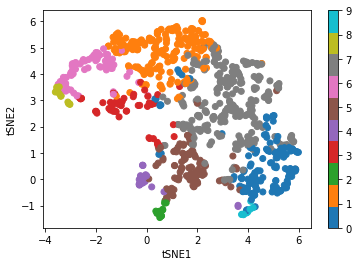

In [145]:
plt.scatter(x=embedding[:,0], y=embedding[:,1], c=np.array(cl), cmap='tab10')
plt.xlabel('tSNE1')
plt.ylabel('tSNE2')
plt.colorbar()
plt.show()

In [146]:
from collections import Counter
d = Counter(cl)

sorted(d.items(), key = lambda x: x[1], reverse=True)

[(7, 300),
 (1, 226),
 (0, 156),
 (5, 104),
 (6, 86),
 (3, 55),
 (4, 29),
 (2, 18),
 (8, 15),
 (9, 11)]

In [126]:
mean_squared_error(X[:,:200].T, np.zeros(X[:,:200].T.shape), squared=False)

12.022478945708327